In [50]:
import sympy as sp
import numpy as np
from scipy.integrate import nquad,quad
from tqdm import tqdm
import matplotlib.pyplot as plt

## 调用函数
以下两个函数用于计算矩阵A，尝试使用符号计算直接进行积分的求解，结果证实算法速度过慢。因此采用符号计算求得泰勒级数，而后转而使用数值计算求解，在积分区间附近可以达到比较好的效果。

In [51]:
def construct_A(n,basis_list,basis_point):
    matrix_A = sp.zeros(n+1)
    pos = []
    for p in range(0, n+1):
        for q in range(0, n+1):
            pos.append([p,q])
    for item in tqdm(pos):
        matrix_A = create_series(matrix_A,item,basis_list,basis_point)
    Lambda_diag = Lambda*np.matrix(np.diag(np.ones(n+1)))
    return Lambda_diag - matrix_A

In [52]:
def create_series(matrix_A,pos,basis_list,basis_point):
    t = basis_point[pos[0]]
    fi = basis_list[pos[1]]
    n_y = K.subs(x,t)*fi.subs(x,y)
    n_y_numpy = sp.lambdify(y,n_y,'numpy')
    #n_result = n_taylor_x.integrate((x,begin,end))
    n_result,_ = quad(n_y_numpy,begin,end)
    matrix_A[pos[0],pos[1]] = n_result
    return matrix_A

In [53]:
def generate_basis(method,begin,end,n):
    feature = 2*sp.pi/(end-begin)
    x = sp.Symbol('x')
    basis_list = []
    basis_point = []
    if method == 'linear':
        skip = (end-begin)/n
        for i in tqdm(range(n+1)):
            temp_begin = begin+(i-1)*skip
            temp_end = temp_begin+2*skip
            basis_list.append(sp.Piecewise((0, x < temp_begin),(0, x > temp_end),(1-sp.Abs(x-temp_begin-skip)/skip, True)))
            basis_point.append(begin+i*skip)  
    if method == 'trigo':
        skip = (end-begin)*2*sp.pi/(2*n+1)/feature
        for i in tqdm(range(2*n+1)):
            temp_begin = begin+i*skip
            basis_list.append(1/(2*n+1)*sp.sin(feature*(n+1/2)*(x-temp_begin))/sp.sin((x-temp_begin)/2*feature))
            basis_point.append(temp_begin)
    return basis_list,basis_point

### 封装配置法函数。

输入： $n$  基个数

输出： $result$  输出配置法求得的解

In [54]:
def Projection_method(n):
    basis_list,basis_point = generate_basis(method,begin,end,n)
    if method == 'linear':
        m = n
    elif method == 'trigo':
        m = 2*n
    A_n = construct_A(m,basis_list,basis_point)
    y_ = sp.zeros(m+1,1)
    for i in tqdm(range(m+1)):
        try:
            y_[i, 0] = g.evalf(subs={x:basis_point[i]})
        except Exception:
            y_[i, 0] = g.evalf(subs = {x:basis_point[i]+tolerance})
    A_n_acce = np.matrix(A_n).astype(np.float64)
    A_n_acce_inv = A_n_acce**(-1)
    A_n_inv = sp.Matrix(A_n_acce_inv)
    c = A_n_inv*y_
    result = 0
    for i in range(m+1):
        result = result + basis_list[i]*c[i,0]
    return result

### 迭代函数

In [55]:
def iteration(f_origin,n):
    global ax
#     N = 250
#     tolerance = 10**(-8)
    f_iter_list = []
#     xx = np.linspace(begin,end,N)
    for item in tqdm(xx):
        try:
            f_iter_list.append(result.evalf(subs={x:item}))
        except Exception as e:
            f_iter_list.append(result.evalf(subs={x:item+tolerance}))
    ax.plot(xx,f_iter_list,label=f'{n}')
    f_iter_list = iter_IE(f_iter_list)
    return f_iter_list

In [56]:
def iter_IE(f_iter):
    f_iter_new = []
    yy = np.linspace(begin,end,N)
    foot = (end-begin)/N
    for item in tqdm(xx):
        result = 0
        for i in range(N):
            try:
                result = result + K.evalf(subs={x:item,y:yy[i]})*f_iter[i]*foot
            except Exception:
                result = result + K.evalf(subs={x:item+tolerance,y:yy[i]+tolerance})*f_iter[i]*foot
        try:
            f_iter_new.append(1/Lambda*(g.evalf(subs={x:item})+result))
        except Exception as e:
            f_iter_new.append(1/Lambda*(g.evalf(subs={x:item+tolerance})+result))
    return f_iter_new

## 主函数
本程序通过投影方法中的配置法求解第二类Fredholm方程。
$$\lambda f(x) - \int_a^{b} k(x,y)f(y) dy = g(x)$$

In [57]:
x = sp.Symbol('x')
y = sp.Symbol('y')

In [58]:
Lambda = 1
K = sp.sin(x*y)*x*y**2
begin = 0
end = 1
f_origin = 1+sp.exp(x)+x**2
method = 'trigo'
start = 6
total = 4
span = 2
y_tol = 10  # 设置y的区间，避免有几条函数曲线在端点出现爆炸

In [59]:
g = Lambda*f_origin-(K*f_origin.subs(x,y)).integrate((y,begin,end))
g

x**2 - Piecewise((0, Eq(x, 0)), (-x*(4*x**8/(x**11 + 3*x**9 + 3*x**7 + x**5) - 24*x**6/(x**11 + 3*x**9 + 3*x**7 + x**5) - 66*x**4/(x**11 + 3*x**9 + 3*x**7 + x**5) - 70*x**2/(x**11 + 3*x**9 + 3*x**7 + x**5) - 24/(x**11 + 3*x**9 + 3*x**7 + x**5)) + x*(-E*x**10*cos(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) - 2*x**10*cos(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) + 6*x**9*sin(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) + 3*E*x**9*sin(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) + 8*x**8*cos(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) + 4*E*x**8*cos(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) - 4*E*x**7*sin(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) - 6*x**7*sin(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) - 3*E*x**6*cos(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) + 12*x**6*cos(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) - 54*x**5*sin(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) + E*x**5*sin(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) - 32*x**4*cos(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) - 66*x**3*sin(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) - 58*x**2*cos(x)/(x**11 + 3*x**9 + 3*x**7 + x**5) -

100%|██████████| 100/100 [00:00<00:00, 8931.84it/s]


正在处理n=6的情况：


100%|██████████| 100/100 [00:03<00:00, 26.55it/s]


正在处理n=8的情况：


100%|██████████| 100/100 [00:03<00:00, 25.56it/s]


正在处理n=10的情况：


100%|██████████| 100/100 [00:03<00:00, 26.63it/s]


正在处理n=12的情况：


100%|██████████| 100/100 [00:03<00:00, 26.59it/s]


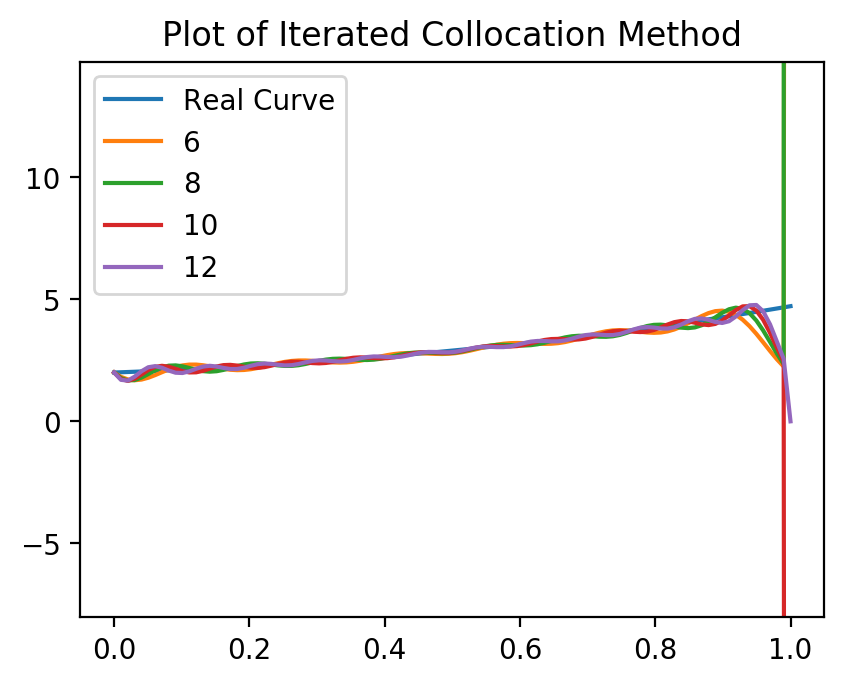

In [60]:
err_all = []
N = 50*(int(end-begin)+1)
tolerance = 10**(-8)
err_iter=[]
xx = np.linspace(begin,end,N)
f_origin_list = []
for item in tqdm(xx):
    try:
        f_origin_list.append(f_origin.evalf(subs={x:item}))
    except Exception as e:
        f_origin_list.append(f_origin.evalf(subs={x:item+tolerance}))
y_MAX = np.max(f_origin_list)
y_MIN = np.min(f_origin_list)
fig,ax=plt.subplots(1,1)
plt.title('Plot of Iterated Collocation Method')
ax.plot(xx,f_origin_list,label=f'Real Curve')
for i in range(start,start+total*span,span):
    print(f'正在处理n={i}的情况：')
    result = Projection_method(i)
    f_iter_list = iteration(result,i)
    err = np.array(f_origin_list)-np.array(f_iter_list)
    err_norm2 = np.sum(err**2)/N
    err_iter.append(err_norm2)
ax.legend()
plt.ylim((float(y_MIN-y_tol),float(y_MAX+y_tol)))
plt.show()

[0.947831586798437, 16.3606899211974, 1.11121573405846, 0.000866742050057951]


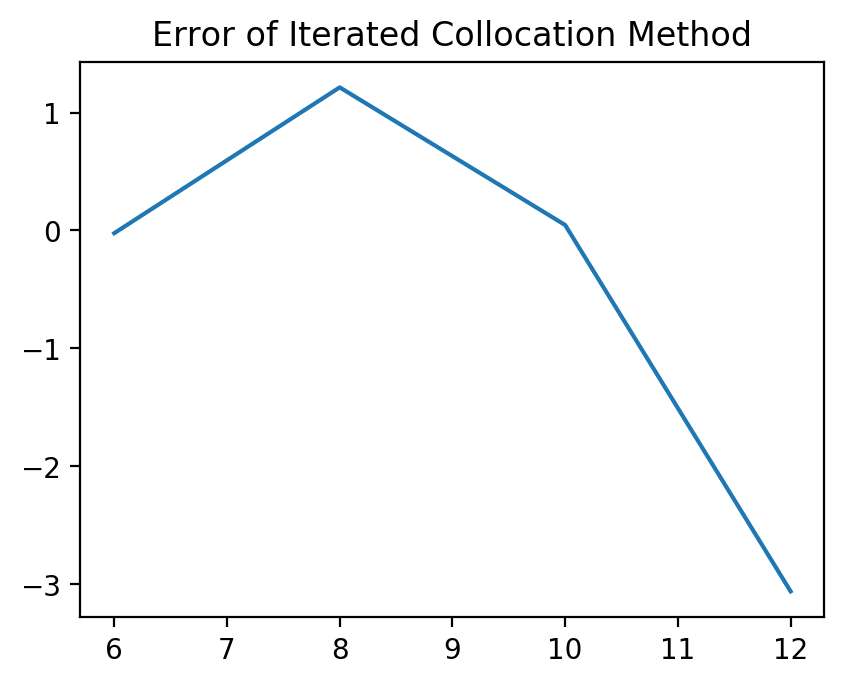

In [61]:
plt_err,ax_err = plt.subplots(1,1) 
plt.title('Error of Iterated Collocation Method')
ax_err.plot(np.arange(start,start+total*span,span),[np.log10(float(x)) for x in err_iter])
print(err_iter)